In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder \
     .appName("Test") \
     .getOrCreate()

In [ ]:
import urllib.request  # lib that handles URLs
import io
import pandas as pd
pd.options.display.max_rows=250
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

# Get GDELT Schema

In [76]:
target_url="https://raw.githubusercontent.com/linwoodc3/gdelt2HeaderRows/master/schema_csvs/GDELT_2.0_Events_Column_Labels_Header_Row_Sep2016.csv"
data = urllib.request.urlopen(target_url).read().decode('utf8')
formats = pd.read_csv(io.StringIO(data))
colnames_events = list(formats["tableId"])

target_url="https://raw.githubusercontent.com/linwoodc3/gdelt2HeaderRows/master/schema_csvs/GDELT_2.0_eventMentions_Column_Labels_Header_Row_Sep2016.tsv"
data = urllib.request.urlopen(target_url).read().decode('utf8')
formats = pd.read_csv(io.StringIO(data),sep="\t")
colnames_mentions = list(formats.loc[:15,"0"])

target_url="https://raw.githubusercontent.com/linwoodc3/gdelt2HeaderRows/master/schema_csvs/GDELT_2.0_gdeltKnowledgeGraph_Column_Labels_Header_Row_Sep2016.tsv"
data = urllib.request.urlopen(target_url).read().decode('utf8')
formats = pd.read_csv(io.StringIO(data),sep="\t")
colnames_gkg = list(formats["tableId"])

# Dataset Imports

In [7]:
start = datetime.now()

df_events = spark.read.format("csv") \
    .option("header", "false") \
    .option("delimiter","\t") \
    .option("inferSchema", "true") \
    .load(path=["s3://gdelt-open-data/v2/events/2017*.export.csv",
                "s3://gdelt-open-data/v2/events/2018*.export.csv"])
df_events = df_events.toDF(*colnames_events)
df_events.cache()

print(df_events.count())
print(datetime.now()-start)

127869166
0:14:12.976813


In [8]:
df_events.printSchema()

root
 |-- GLOBALEVENTID: integer (nullable = true)
 |-- SQLDATE: integer (nullable = true)
 |-- MonthYear: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- FractionDate: double (nullable = true)
 |-- Actor1Code: string (nullable = true)
 |-- Actor1Name: string (nullable = true)
 |-- Actor1CountryCode: string (nullable = true)
 |-- Actor1KnownGroupCode: string (nullable = true)
 |-- Actor1EthnicCode: string (nullable = true)
 |-- Actor1Religion1Code: string (nullable = true)
 |-- Actor1Religion2Code: string (nullable = true)
 |-- Actor1Type1Code: string (nullable = true)
 |-- Actor1Type2Code: string (nullable = true)
 |-- Actor1Type3Code: string (nullable = true)
 |-- Actor2Code: string (nullable = true)
 |-- Actor2Name: string (nullable = true)
 |-- Actor2CountryCode: string (nullable = true)
 |-- Actor2KnownGroupCode: string (nullable = true)
 |-- Actor2EthnicCode: string (nullable = true)
 |-- Actor2Religion1Code: string (nullable = true)
 |-- Actor2Religion2Code: 

In [16]:
rec = pd.DataFrame(df_events.take(1))
rec.columns = colnames_events
rec.T

,0
GLOBALEVENTID,801430904
SQLDATE,20081112
MonthYear,200811
Year,2008
FractionDate,2008.85
Actor1Code,None
Actor1Name,None
Actor1CountryCode,None
Actor1KnownGroupCode,None
Actor1EthnicCode,None


In [ ]:
start = datetime.now()

df_mentions = spark.read.format("csv") \
    .option("header", "false") \
    .option("delimiter","\t") \
    .option("inferSchema", "true") \
    .load("s3://gdelt-open-data/v2/mentions/20180101*.mentions.csv")
df_mentions = df_mentions.toDF(*colnames_mentions)
df_mentions.cache()

print(datetime.now()-start)

# Basic Queries

### Count of All Events by Day

In [123]:
all_events_by_day = pd.DataFrame(df_events.groupby("SQLDATE").count().collect())
all_events_by_day.columns = ["Date","Count"]
all_events_by_day["Date"] = pd.to_datetime(all_events_by_day["Date"].astype(str), format='%Y%m%d', errors="coerce")
all_events_by_day = all_events_by_day[all_events_by_day["Date"] >= datetime.strptime("2017-01-01","%Y-%m-%d")]
all_events_by_day = all_events_by_day.sort_values(by="Date")

all_events_by_day["Week"] = ((all_events_by_day["Date"].dt.dayofyear-1)//7+1).apply(lambda x: '{0:0>2}'.format(min(x,52)))
all_events_by_day["Year"] = all_events_by_day["Date"].dt.year.astype(str)
all_events_by_day["YearWeek"] = all_events_by_day["Year"] + "-" + all_events_by_day["Week"]

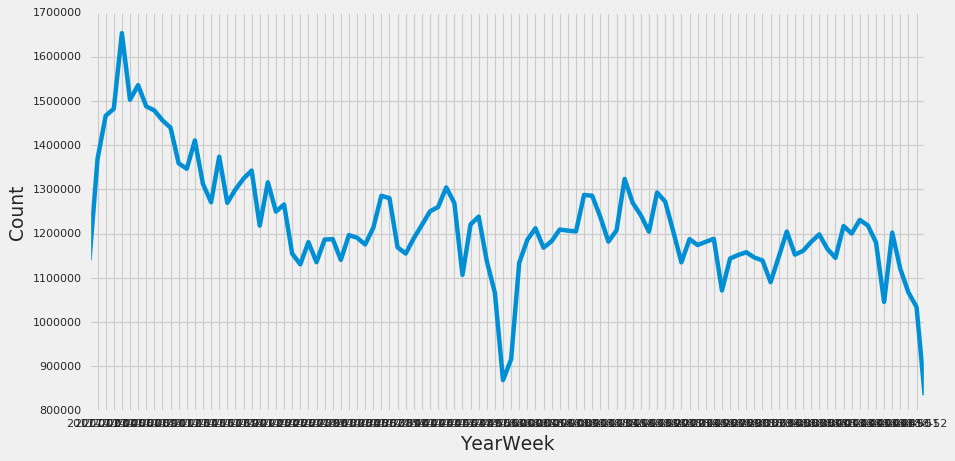

In [146]:
plt.figure(figsize=(12,6))

data = all_events_by_day.groupby(by="YearWeek")["Count"].sum().reset_index()
sns.lineplot(data=data, x="YearWeek", y="Count")

# Stop Spark Context

In [ ]:
sc.stop()